In [1]:
%load_ext autoreload
%autoreload 2

In [51]:
from fastai.vision.all import *
from matplotlib import patches
import torch
import numpy as np
import os
import time
import cv2

In [3]:
path = Path("/home/ubuntu/git/computer-vision/advance/Dataset")
path.ls()

(#2) [Path('/home/ubuntu/git/computer-vision/advance/Dataset/images'),Path('/home/ubuntu/git/computer-vision/advance/Dataset/labels')]

In [4]:
path_im = path/"images"
path_lbl = path/"labels"

path_im.ls(), path_lbl.ls()

((#441) [Path('/home/ubuntu/git/computer-vision/advance/Dataset/images/image_72.jpg'),Path('/home/ubuntu/git/computer-vision/advance/Dataset/images/image_194.jpg'),Path('/home/ubuntu/git/computer-vision/advance/Dataset/images/image_147.jpg'),Path('/home/ubuntu/git/computer-vision/advance/Dataset/images/image_348.jpg'),Path('/home/ubuntu/git/computer-vision/advance/Dataset/images/image_417.jpg'),Path('/home/ubuntu/git/computer-vision/advance/Dataset/images/image_146.jpg'),Path('/home/ubuntu/git/computer-vision/advance/Dataset/images/image_223.jpg'),Path('/home/ubuntu/git/computer-vision/advance/Dataset/images/image_155.jpg'),Path('/home/ubuntu/git/computer-vision/advance/Dataset/images/image_313.jpg'),Path('/home/ubuntu/git/computer-vision/advance/Dataset/images/image_319.jpg')...],
 (#441) [Path('/home/ubuntu/git/computer-vision/advance/Dataset/labels/label_145.png'),Path('/home/ubuntu/git/computer-vision/advance/Dataset/labels/label_436.png'),Path('/home/ubuntu/git/computer-vision/adv

In [5]:
fnames = get_image_files(path_im)
lnames = get_image_files(path_lbl)
fnames, lnames

((#441) [Path('/home/ubuntu/git/computer-vision/advance/Dataset/images/image_72.jpg'),Path('/home/ubuntu/git/computer-vision/advance/Dataset/images/image_194.jpg'),Path('/home/ubuntu/git/computer-vision/advance/Dataset/images/image_147.jpg'),Path('/home/ubuntu/git/computer-vision/advance/Dataset/images/image_348.jpg'),Path('/home/ubuntu/git/computer-vision/advance/Dataset/images/image_417.jpg'),Path('/home/ubuntu/git/computer-vision/advance/Dataset/images/image_146.jpg'),Path('/home/ubuntu/git/computer-vision/advance/Dataset/images/image_223.jpg'),Path('/home/ubuntu/git/computer-vision/advance/Dataset/images/image_155.jpg'),Path('/home/ubuntu/git/computer-vision/advance/Dataset/images/image_313.jpg'),Path('/home/ubuntu/git/computer-vision/advance/Dataset/images/image_319.jpg')...],
 (#441) [Path('/home/ubuntu/git/computer-vision/advance/Dataset/labels/label_145.png'),Path('/home/ubuntu/git/computer-vision/advance/Dataset/labels/label_436.png'),Path('/home/ubuntu/git/computer-vision/adv

<AxesSubplot:>

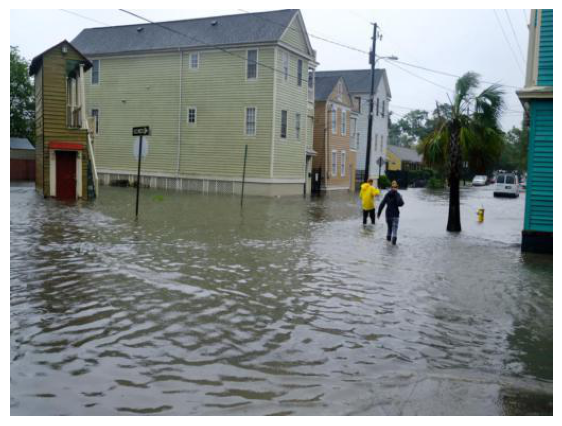

In [6]:
idx = 15

img_fn = fnames[idx]
img = PILImage.create(img_fn)
img.show(figsize=(7,7))

In [7]:
get_mask = lambda o: path/'labels'/str('label_'+o.stem.split('_')[1]+'.png')

<AxesSubplot:>

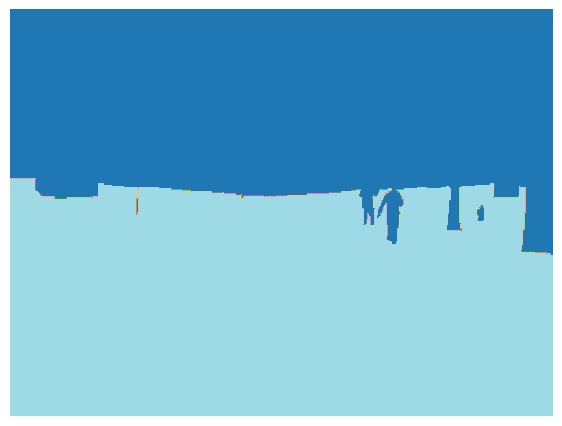

In [8]:
msk = PILMask.create(get_mask(img_fn))
msk.show(figsize=(7,7), alpha=1)

In [9]:
m = tensor(msk).squeeze(1) != 0

tensor(msk)[m], tensor(msk)[m].shape, tensor(msk).shape

(tensor([1, 1, 1,  ..., 1, 1, 1], dtype=torch.uint8),
 torch.Size([105678]),
 torch.Size([384, 512]))

In [10]:
sz = msk.shape
sz

(384, 512)

In [11]:
h_sz = tuple(int(x/2) for x in sz)
h_sz

(192, 256)

In [12]:
codes = ['bg', 'flood']

In [13]:
db = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   splitter=RandomSplitter(),
                   get_y=get_mask,
                   batch_tfms=[*aug_transforms(size=h_sz), Normalize.from_stats(*imagenet_stats)])

In [14]:
dls = db.dataloaders(path_im, bs=8)

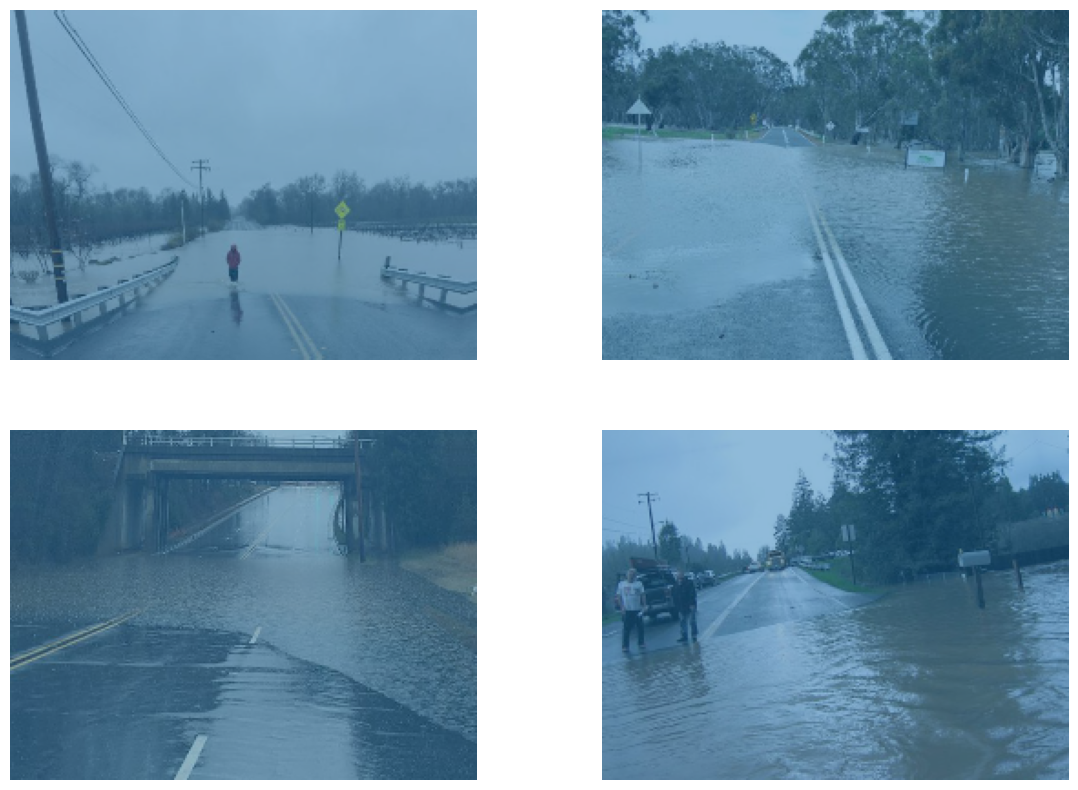

In [15]:
dls.show_batch(max_n=4, vmin=1, vmax=30, figsize=(14,10))

In [17]:
def acc_flood(inp, targ):
  targ = targ.squeeze(1)
  mask = targ != 0
  return (inp.argmax(dim=1)[mask]==targ[mask]).float().mean()

In [18]:
learn = unet_learner(dls, resnet34, metrics=acc_flood, self_attention=True, act_cls=Mish, opt_func=ranger)

/home/ubuntu/mambaforge/envs/fastai/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/mambaforge/envs/fastai/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
learn.summary()

DynamicUnet (Input shape: 8 x 3 x 192 x 256)
Layer (type)         Output Shape         Param #    Trainable 
                     8 x 64 x 96 x 128   
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     8 x 64 x 48 x 64    
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                      

SuggestedLRs(valley=7.585775892948732e-05)

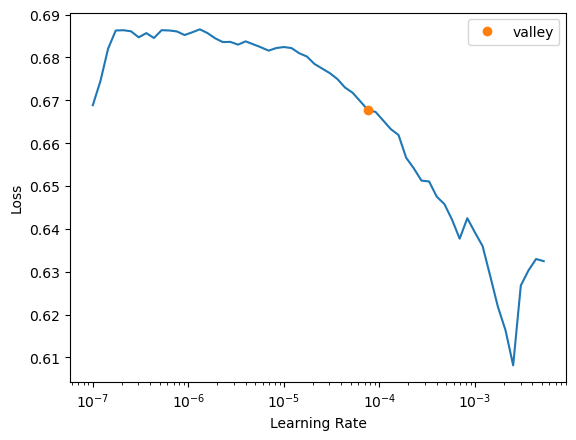

In [20]:
learn.lr_find()

In [21]:
lr = 7e-5

In [22]:
learn.fit_flat_cos(10, slice(lr))

In [23]:
learn.save('md-s1')
learn.load('md-s1');

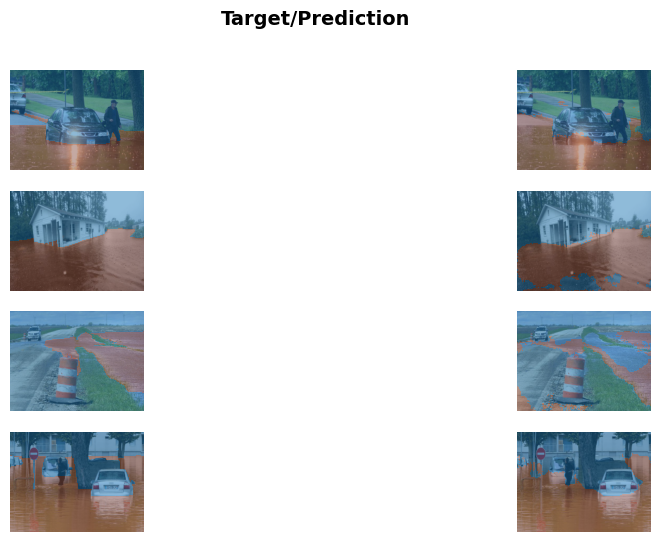

In [24]:
learn.show_results(max_n=4, figsize=(12,6))

In [25]:
lrs = slice(lr/400, lr/4)

In [26]:
learn.unfreeze()

In [27]:
learn.fit_flat_cos(12, lrs)

In [28]:
learn.save('md-1')

Path('models/md-1.pth')

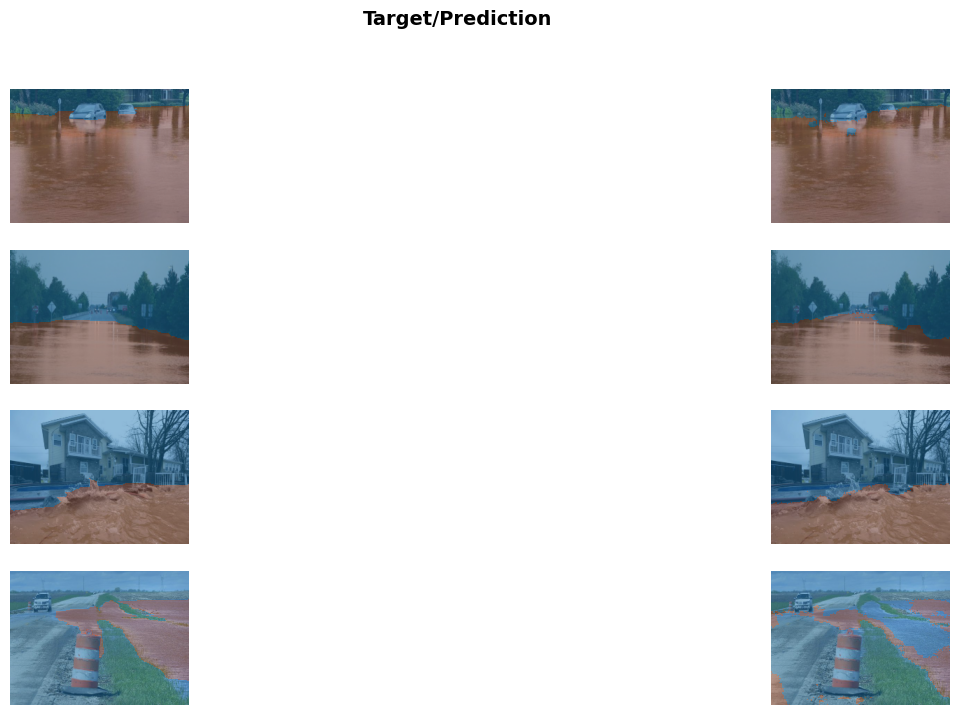

In [30]:
learn.show_results(max_n=4, figsize=(18,8))

In [39]:
pred = learn.predict(img_fn)
pred

(TensorMask([[0, 0, 0,  ..., 0, 0, 0],
             [0, 0, 0,  ..., 0, 0, 0],
             [0, 0, 0,  ..., 0, 0, 0],
             ...,
             [1, 1, 1,  ..., 1, 1, 1],
             [1, 1, 1,  ..., 1, 1, 1],
             [1, 1, 1,  ..., 1, 1, 1]]),
 TensorBase([[0, 0, 0,  ..., 0, 0, 0],
             [0, 0, 0,  ..., 0, 0, 0],
             [0, 0, 0,  ..., 0, 0, 0],
             ...,
             [1, 1, 1,  ..., 1, 1, 1],
             [1, 1, 1,  ..., 1, 1, 1],
             [1, 1, 1,  ..., 1, 1, 1]]),
 TensorBase([[[0.7488, 0.8336, 0.9677,  ..., 0.9847, 0.9485, 0.8644],
              [0.7911, 0.8674, 0.9736,  ..., 0.9864, 0.9226, 0.8905],
              [0.8939, 0.9509, 0.9951,  ..., 0.9964, 0.9900, 0.9843],
              ...,
              [0.3554, 0.2527, 0.1585,  ..., 0.2395, 0.3121, 0.3082],
              [0.3471, 0.2637, 0.1967,  ..., 0.1962, 0.3211, 0.3086],
              [0.3892, 0.3206, 0.2788,  ..., 0.2652, 0.3412, 0.3345]],
 
             [[0.2512, 0.1664, 0.0323,  ..., 0.015

In [42]:
pred[2].shape

torch.Size([2, 192, 256])

678 ms ± 39.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


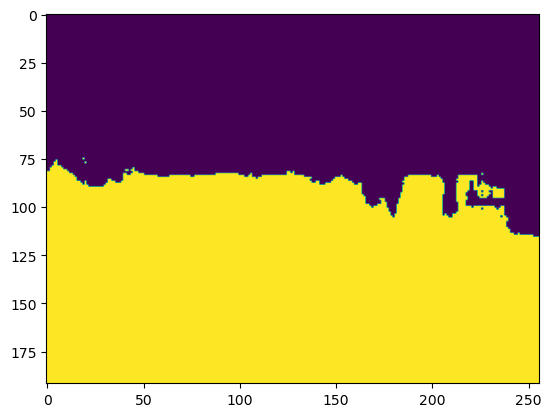

In [44]:
%%timeit
pred = learn.predict(img_fn)
pred_arx = pred[2].argmax(dim=0)
plt.imshow(pred_arx)

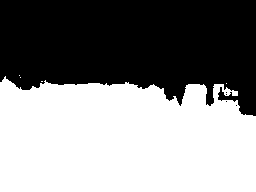

In [57]:
pred = learn.predict(img_fn)
pred_arx = pred[2].argmax(dim=0)
pred_arx = pred_arx.numpy()
rescaled = (255.0 / pred_arx.max() * (pred_arx - pred_arx.min())).astype(np.uint8)
im = Image.fromarray(rescaled)
im

In [61]:
vid_path = "/home/ubuntu/git/computer-vision/advance/vid/input/flood-vid.mp4"
vid = cv2.VideoCapture(vid_path)
codec = cv2.VideoWriter_fourcc(*'XVID')
fps = int(vid.get(cv2.CAP_PROP_FPS))
print(fps)
w, h = int(vid.get(cv2.CAP_PROP_FRAME_WIDTH)), int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT))
out_path = '/home/ubuntu/git/computer-vision/advance/vid/output/seg-vid.4'
out = cv2.VideoWriter(out_path,codec, fps, (w,h))

0


In [60]:
%%timeit
while True:
    
    _, img = vid.read()
    
    if img is None:
        print('Phew Done')
        break
    else:
        pred = learn.predict(img)
        pred_arx = pred[2].argmax(dim=0)
        pred_arx = pred_arx.numpy()
        rescaled = (255.0 / pred_arx.max() * (pred_arx - pred_arx.min())).astype(np.uint8)
        im = Image.fromarray(rescaled)
        out.write(cv2.cvtColor(numpy.array(im), cv2.COLOR_RGB2BGR))
    
    if cv2.waitKey(1) == ord('q'):
        break
vid.release()
cv2.destroyAllWindows()
    

Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
Phew Done
